# Whisper v3 Phonology Inference Analysis

**Goal:** Explain model behavior by relating phonological features to Word Error Rate, and compare **original** vs **Cartesia-transformed** audio.

**Dataset:** French & Spanish utterances with acoustic features (RMS amplitude, DC offset, articulation rate, mean pitch, pitch std. dev., HNR) and WER labels for original and transformed audio. Main code lives here; preprocessing & cleaning scripts are in `Data/`.

**Structure:**
1. Data preparation  
2. Descriptive statistics  
3. Δ-regressions  
4. WER_orig → WER_trans mapping  
5. Holdout validation  
6. Conclusions  

## 1. Data preparation

*Purpose:* Load files, align original vs transformed data, split into training/holdout, sanity checks.

In [1]:
# === Config ===
from pathlib import Path
LANGUAGES = ["french", "spanish"]          # analyze separately
DATA_ROOT = Path("data")                    # change to your dataset root (relative to notebook)
ORIG_DIR = DATA_ROOT / "Acoustic Lines (with WER), Cleaned" # original
TRANS_DIR = DATA_ROOT / "Transformed Acoustic Lines (with WER), Cleaned" # transformed

# filename like "belgium_female_individual_sample_features.csv"
FILENAME_RE = r"(?P<country>[a-z_]+)_(?P<gender>male|female).+\.csv"

FEATURES = ["rms_amplitude","dc_offset","articulation_rate","mean_pitch","pitch_std_dev","hnr"]
OUTCOME = "wer_score"
ID_COLS = ["speaker_id","line_id"]
GROUP_COLS = ["country","gender","language"]
RANDOM_SEED = 7

# ----- Tell the notebook which countries are FR vs ES -----
SPANISH_COUNTRIES = {
    "spain","argentina","chile","mexico","dominican_republic"
}
FRENCH_COUNTRIES = {
    "france","belgium","canada","senegal","ivory_coast"
}

def country_to_language(country: str) -> str:
    c = country.lower()
    if c in SPANISH_COUNTRIES: return "spanish"
    if c in FRENCH_COUNTRIES:  return "french"
    raise ValueError(f"Country not in mapping: {country}")

LANGUAGES = ["french","spanish"]

In [2]:
# === Imports ===
import re, math, json, warnings, numpy as np, pandas as pd
from dataclasses import dataclass
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.robust.norms import HuberT
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, binomtest, pearsonr
warnings.filterwarnings("ignore")
np.random.seed(RANDOM_SEED)


In [3]:
# === Helper functions ===
def parse_meta_from_filename(path: Path, language: str):
    m = re.search(FILENAME_RE, path.name)
    if not m:
        raise ValueError(f"Filename doesn't match expected pattern: {path.name}")
    return {
        "country": m.group("country"),
        "gender": m.group("gender"),
        "language": language
    }

def load_language_tables(language: str, base_orig: Path, base_trans: Path):
    """
    Scan ORIG_DIR and TRANS_DIR, use country->language map to keep only files for the requested `language`.
    """
    def load_dir(d: Path, treatment_flag: int):
        frames = []
        for p in sorted(d.glob("*.csv")):
            m = re.search(FILENAME_RE, p.name, flags=re.IGNORECASE)
            if not m: 
                continue
            country = m.group("country").lower()
            gender  = m.group("gender").lower()
            lang = country_to_language(country)
            if lang != language:
                continue
            df = pd.read_csv(p)

            # --- fix speaker_id mismatch ---
            if treatment_flag == 1 and "original_speaker_id" in df.columns:
                df = df.rename(columns={"original_speaker_id": "speaker_id"})

            df["country"]   = country
            df["gender"]    = gender
            df["language"]  = lang
            df["treatment"] = treatment_flag
            frames.append(df)
        if not frames:
            raise FileNotFoundError(f"No CSVs for language='{language}' in {d}")
        return pd.concat(frames, ignore_index=True)

    orig  = load_dir(base_orig, 0)
    trans = load_dir(base_trans, 1)
    return orig, trans


def zscore_within_language(df: pd.DataFrame, feature_cols):
    # standardize features within each language on pooled (orig+trans) data
    df = df.copy()
    for lang, sub in df.groupby("language"):
        scaler = StandardScaler()
        vals = scaler.fit_transform(sub[feature_cols])
        df.loc[sub.index, [f"{c}_z" for c in feature_cols]] = vals
    return df

def make_line_paired_deltas(orig: pd.DataFrame, trans: pd.DataFrame, feature_cols):
    # Inner-join on (country, gender, language, speaker_id, line_id)
    idx_cols = ["country","gender","language","speaker_id","line_id"]
    left = orig[idx_cols + feature_cols + [OUTCOME]].rename(columns={c:f"{c}_orig" for c in feature_cols+[OUTCOME]})
    right = trans[idx_cols + feature_cols + [OUTCOME]].rename(columns={c:f"{c}_trans" for c in feature_cols+[OUTCOME]})
    merged = pd.merge(left, right, on=idx_cols, how="inner")
    if merged.empty:
        print("No line-level pairs found after inner join. Check IDs/cleaning.")
    # deltas
    for c in feature_cols:
        merged[f"d_{c}"] = merged[f"{c}_trans"] - merged[f"{c}_orig"]
    merged["d_wer"] = merged[f"{OUTCOME}_trans"] - merged[f"{OUTCOME}_orig"]
    # log1p WER
    merged["d_log1p_wer"] = np.log1p(merged[f"{OUTCOME}_trans"]) - np.log1p(merged[f"{OUTCOME}_orig"])
    return merged

def make_speaker_paired_deltas(orig: pd.DataFrame, trans: pd.DataFrame, feature_cols):
    grp = ["country","gender","language","speaker_id"]
    agg = {c:"mean" for c in feature_cols+[OUTCOME]}
    o = orig.groupby(grp, as_index=False).agg(agg).rename(columns={c:f"{c}_orig" for c in feature_cols+[OUTCOME]})
    t = trans.groupby(grp, as_index=False).agg(agg).rename(columns={c:f"{c}_trans" for c in feature_cols+[OUTCOME]})
    merged = pd.merge(o, t, on=grp, how="inner")
    # counts for weights
    cnt_o = orig.groupby(grp)["line_id"].count().rename("n_orig")
    cnt_t = trans.groupby(grp)["line_id"].count().rename("n_trans")
    merged = merged.merge(cnt_o, on=grp).merge(cnt_t, on=grp)
    merged["weight"] = 2 * merged["n_orig"] * merged["n_trans"] / (merged["n_orig"] + merged["n_trans"]).replace(0, np.nan)
    for c in feature_cols:
        merged[f"d_{c}"] = merged[f"{c}_trans"] - merged[f"{c}_orig"]
    merged["d_wer"] = merged[f"{OUTCOME}_trans"] - merged[f"{OUTCOME}_orig"]
    merged["d_log1p_wer"] = np.log1p(merged[f"{OUTCOME}_trans"]) - np.log1p(merged[f"{OUTCOME}_orig"])
    return merged

def make_pooled_long(orig: pd.DataFrame, trans: pd.DataFrame):
    pooled = pd.concat([orig, trans], ignore_index=True)
    pooled["log1p_wer"] = np.log1p(pooled[OUTCOME])
    return pooled

def bh_fdr(pvals, alpha=0.05):
    rej, pcor, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    return rej, pcor


In [5]:
# === Load data ===
all_results = {}
for language in LANGUAGES:
    print(f"Loading language: {language}")
    orig, trans = load_language_tables(language, ORIG_DIR, TRANS_DIR)
    # attach to dict
    all_results[language] = {
        "orig": orig,
        "trans": trans,
        "line_paired": make_line_paired_deltas(orig, trans, FEATURES),
        "speaker_paired": make_speaker_paired_deltas(orig, trans, FEATURES),
        "pooled": make_pooled_long(orig, trans),
    }
print("Done.")


Loading language: french
Loading language: spanish
Done.


In [9]:
# === Create Train / Holdout Split ===

HOLDOUT_FRAC = 0.10
RANDOM_SEED  = 7

# Concatenate all pooled rows (both orig+trans, all langs)
all_pooled = pd.concat(
    [d["pooled"].assign(lang=lang) for lang,d in all_results.items()],
    ignore_index=True
)

total_rows = len(all_pooled)

# Split speakers so orig+trans stay together
unique_speakers = all_pooled["speaker_id"].astype(str).unique()
train_speakers, holdout_speakers = train_test_split(
    unique_speakers,
    test_size=HOLDOUT_FRAC,
    random_state=RANDOM_SEED
)

# Tag train vs holdout
for lang, d in all_results.items():
    for key in ["orig","trans","line_paired","speaker_paired","pooled"]:
        df = d[key]
        d[key] = df.assign(
            split=np.where(df["speaker_id"].astype(str).isin(train_speakers),
                           "train","holdout")
        )

all_results_train   = {}
all_results_holdout = {}

for lang, d in all_results.items():
    res_train, res_hold = {}, {}
    for key in ["orig","trans","line_paired","speaker_paired","pooled"]:
        df = d[key]
        res_train[key] = df.query("split=='train'").drop(columns="split")
        res_hold[key]  = df.query("split=='holdout'").drop(columns="split")
    all_results_train[lang]   = res_train
    all_results_holdout[lang] = res_hold

train_rows   = sum(len(d["pooled"]) for d in all_results_train.values())
holdout_rows = sum(len(d["pooled"]) for d in all_results_holdout.values())

# Sanity checks
print("Built all_results_train and all_results_holdout")
print(f"Total pooled rows before split: {total_rows}")
print(f"Training pooled rows:           {train_rows}")
print(f"Holdout pooled rows:            {holdout_rows}")
print(f"Check: train + holdout = {train_rows + holdout_rows} (should equal {total_rows})")

all_results = all_results_train


Built all_results_train and all_results_holdout
Total pooled rows before split: 6162
Training pooled rows:           5483
Holdout pooled rows:            679
Check: train + holdout = 6162 (should equal 6162)


In [10]:
# Descriptives & sanity checks
for language, d in all_results.items():
    print(f"\n--- {language.upper()} ---")
    lp = d["line_paired"]
    sp = d["speaker_paired"]
    pooled = d["pooled"]
    print(f"Line-paired rows: {len(lp):,}")
    print(f"Speaker-paired rows: {len(sp):,}")
    print(f"Pooled rows: {len(pooled):,}")
    
    # Basic summaries
    print(pooled.groupby("treatment")[OUTCOME].describe()[["mean","std","50%","min","max"]])
    
    # Improvement counts (line-paired only)
    if len(lp):
        improved = (lp["d_wer"] < 0).sum()
        worsened = (lp["d_wer"] >= 0).sum()
        print(f"Improved (ΔWER<0): {improved}, Worsened: {worsened}")



--- FRENCH ---
Line-paired rows: 1,336
Speaker-paired rows: 85
Pooled rows: 3,067
                mean        std       50%  min         max
treatment                                                 
0           5.430260   7.780781  3.570000  0.0  114.630000
1          11.391495  10.847433  8.541033  0.0  117.073171
Improved (ΔWER<0): 192, Worsened: 1144

--- SPANISH ---
Line-paired rows: 738
Speaker-paired rows: 31
Pooled rows: 2,416
               mean        std       50%  min    max
treatment                                           
0          5.063653   7.646508  3.508772  0.0  120.0
1          8.645008  13.140241  6.250000  0.0  200.0
Improved (ΔWER<0): 83, Worsened: 655


## 2. General OLS Models
*Purpose:* Establish baseline regressions of WER against phonological features to see which factors correlate with recognition difficulty. Uses the full dataset of original and transformed data

### 2.1 Baseline OLS

In [11]:
# Simple OLS regressions: WER ~ standardized features

def run_simple_ols_standardized(df, label):
    X = df[FEATURES].copy()
    y = df[OUTCOME]
    X = (X - X.mean()) / X.std(ddof=0)  # Standardize predictors (z-score within this subset)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n--- OLS (standardized features): {label} ---")
    print(model.summary())
    return model

# Combined dataset (after applying train/holdout filter)
all_pooled = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)

ols_all_std     = run_simple_ols_standardized(all_pooled, "All data (FR + ES)")
ols_french_std  = run_simple_ols_standardized(all_pooled.query("language=='french'"),  "French only")
ols_spanish_std = run_simple_ols_standardized(all_pooled.query("language=='spanish'"), "Spanish only")



--- OLS (standardized features): All data (FR + ES) ---
                            OLS Regression Results                            
Dep. Variable:              wer_score   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     33.86
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           2.34e-40
Time:                        09:14:48   Log-Likelihood:                -20187.
No. Observations:                5483   AIC:                         4.039e+04
Df Residuals:                    5476   BIC:                         4.043e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

- Very low R^2: a very little share of the variance in WER is explained by these features --> Probably have missing features here. (e.g. acoustic quality, lexical difficulty...)
- But several features have low p-values, suggesting statistical significancy:
    - All Data regression: all have p<0.05 ==> *articulation_rate, mean_pitch, rms_amplitude look like the strongest drivers*
    - French regression: same ==> *articulation_rate, mean_pitch, rms_amplitude look like the strongest drivers*
    - Spanish regression: all except rms_amplitude, pitch_std_dev, and hnr are significant ==> seems like these features don't matter as much for spanish, strongest drivers seem to be *articulation_rate, mean_pitch*
- Sign of the coefficients: consistent across all 3 regressions, mean pitch and dc offset are negative and the others are positive
- Generally, suggests Whisper is especially sensitive to articulation rate and mean pitch, as well as rms amplitude in the case of french. DC offset also seems significant across all regressions

### 2.2 Multicollinearity, homoscedasticity, linearity


--- VIF (All data) ---
const                60.916547
rms_amplitude         1.019505
dc_offset             1.012796
articulation_rate     1.020591
mean_pitch            2.098789
pitch_std_dev         1.498412
hnr                   1.566830
Name: VIF, dtype: float64

--- VIF (French only) ---
const                56.707662
rms_amplitude         1.025192
dc_offset             1.010776
articulation_rate     1.049994
mean_pitch            2.321127
pitch_std_dev         1.661006
hnr                   1.718260
Name: VIF, dtype: float64

--- VIF (Spanish only) ---
const                82.112249
rms_amplitude         1.136142
dc_offset             1.029841
articulation_rate     1.054924
mean_pitch            1.837689
pitch_std_dev         1.383192
hnr                   1.433440
Name: VIF, dtype: float64


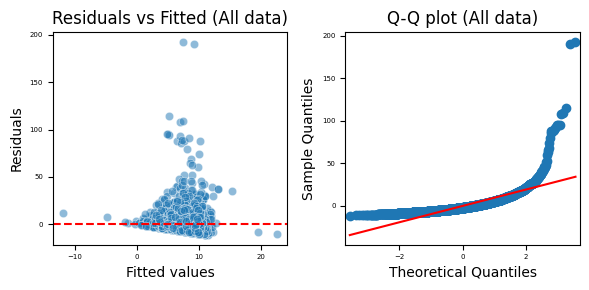

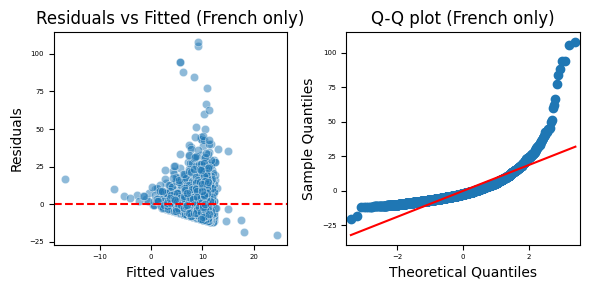

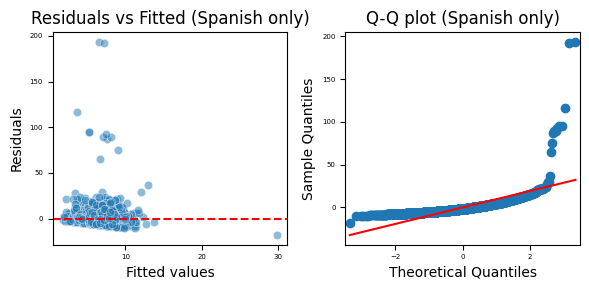

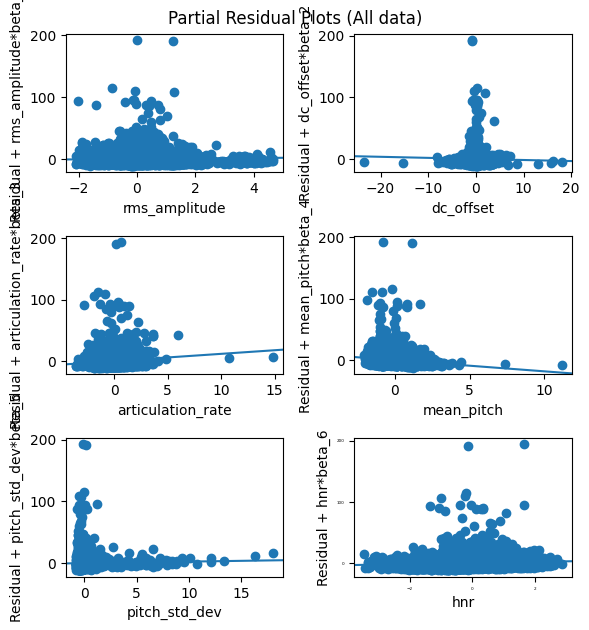

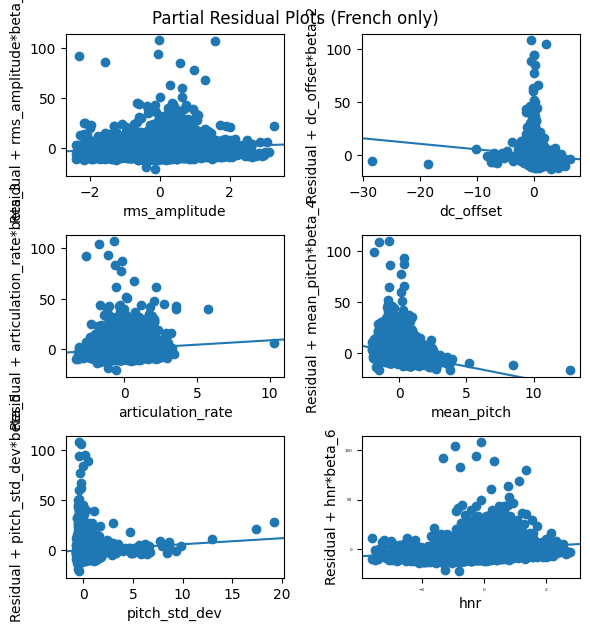

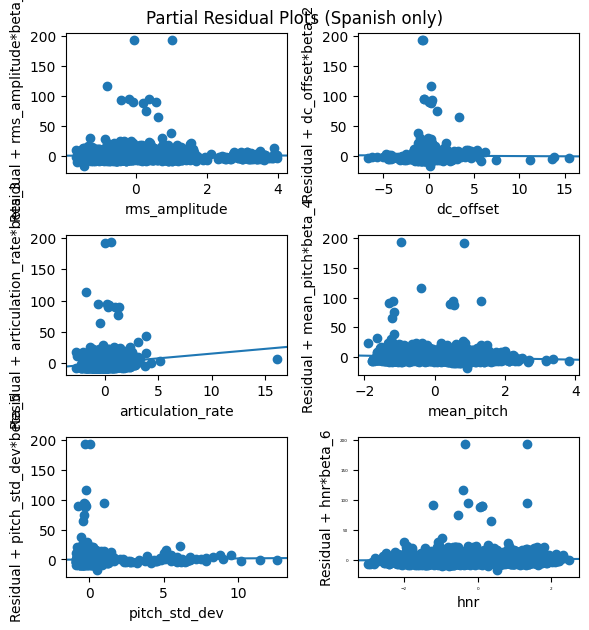

In [15]:
# VIFs, Residuals and QQ plots, Partial Residuals to check for the above
def compute_vif(df, features):
    X = df[features].dropna().copy()
    X = sm.add_constant(X)  # add intercept
    vifs = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns,
        name="VIF"
    )
    return vifs

print("\n--- VIF (All data) ---")
print(compute_vif(all_pooled, FEATURES))
print("\n--- VIF (French only) ---")
print(compute_vif(all_pooled.query("language=='french'"), FEATURES))
print("\n--- VIF (Spanish only) ---")
print(compute_vif(all_pooled.query("language=='spanish'"), FEATURES))


# 2) Residuals vs Fitted & Q-Q plots
def plot_residuals(model, label):
    fitted = model.fittedvalues
    residuals = model.resid

    plt.figure(figsize=(6,3))

    # Residuals vs Fitted
    plt.subplot(1,2,1)
    sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted ({label})")
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)

    # Q-Q Plot for normality
    plt.subplot(1,2,2)
    sm.qqplot(residuals, line="s", ax=plt.gca())
    plt.title(f"Q-Q plot ({label})")
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)

    plt.tight_layout()
    plt.show()

plot_residuals(ols_all_std, "All data")
plot_residuals(ols_french_std, "French only")
plot_residuals(ols_spanish_std, "Spanish only")


# 3) Partial Residual (Component + Residual) plots
def plot_partial_residuals(model, features, label):
    fig = plt.figure(figsize=(6,8))
    sm.graphics.plot_ccpr_grid(model, fig=fig)  # CCPR = Component+Partial Residual
    fig.suptitle(f"Partial Residual Plots ({label})")
    plt.xticks(fontsize=3)
    plt.yticks(fontsize=3)
    plt.show()

plot_partial_residuals(ols_all_std, FEATURES, "All data")
plot_partial_residuals(ols_french_std, FEATURES, "French only")
plot_partial_residuals(ols_spanish_std, FEATURES, "Spanish only")


- **VIFs**: none of the features have VIFs>5, making us more comfortable about potential multicollinearity (this is somewhat surprising given this dataset blends line ids from the same speaker, and original/transformed versions of the same audio snippets). The constant has a high VIF, likely because the features are centered (standardized) so will have high correlation with this vector of all 1s.
- **Residual Plots and QQs**: Regression on all data and on french data have "fanning" pattern, where the variance of residuals seems to increase with fitted values --> indicates heteroscedasticity. The results of the spanish-only regression have a less of a pronounced pattern. For all three regressions there is strong departure from the straight line in the upper tail, indicating non-normal residuals with heavy right tails (this is consistent with the fact that WER can spike sometimes >100%). ==> **OLS assumption of normal residuals is violated, will try to use HC3 (because most conservative) standard errors to deal with this**
- **Partial Residuals**: Mostly indicates linear-looking relationships, with some fanning (confirms heteroscedasticity)

### 2.3 Robust SEs (HC3)

In [13]:
# OLS with HC3 robust SEs

def run_ols_hc3_standardized(df, label, features=FEATURES, outcome=OUTCOME):
    df = df.dropna(subset=features + [outcome]).copy()
    X = df[features]
    X = (X - X.mean()) / X.std(ddof=0)
    X = sm.add_constant(X)
    y = df[outcome]

    model = sm.OLS(y, X).fit(cov_type="HC3")  # <-- robust SEs
    params = model.params.round(2)
    ses    = model.bse.round(2)
    tvals  = model.tvalues.round(2)
    pvals  = model.pvalues.round(2)
    ci     = model.conf_int(alpha=0.05).round(2)

    out = pd.DataFrame({
        "coef": params,
        "robust_se(HC3)": ses,
        "t": tvals,
        "p": pvals,
        "ci_lower": ci[0],
        "ci_upper": ci[1],
    })
    print(f"\n--- OLS (HC3 robust SEs): {label} ---")
    print(f"R^2: {model.rsquared:.3f}   Adj R^2: {model.rsquared_adj:.3f}   N: {int(model.nobs)}")
    display(out)
    return model, out

# Combine pooled data AFTER your 10% holdout filter
all_pooled = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)

# Run with HC3 on the three splits
ols_all_hc3,     tab_all_hc3     = run_ols_hc3_standardized(all_pooled, "All data (FR + ES)")
ols_french_hc3,  tab_fr_hc3      = run_ols_hc3_standardized(all_pooled.query("language=='french'"),  "French only")
ols_spanish_hc3, tab_es_hc3      = run_ols_hc3_standardized(all_pooled.query("language=='spanish'"), "Spanish only")



--- OLS (HC3 robust SEs): All data (FR + ES) ---
R^2: 0.036   Adj R^2: 0.035   N: 5483


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,7.20,0.13,55.44,0.00,6.95,7.46
rms_amplitude,0.36,0.11,3.18,0.00,0.14,0.58
dc_offset,-0.17,0.11,-1.50,0.13,-0.40,0.05
articulation_rate,1.17,0.15,7.65,0.00,0.87,1.47
mean_pitch,-1.83,0.17,-10.84,0.00,-2.16,-1.50
pitch_std_dev,0.25,0.11,2.35,0.02,0.04,0.46
hnr,0.89,0.14,6.44,0.00,0.62,1.16



--- OLS (HC3 robust SEs): French only ---
R^2: 0.062   Adj R^2: 0.060   N: 3067


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,8.03,0.17,47.18,0.0,7.69,8.36
rms_amplitude,1.07,0.17,6.44,0.0,0.75,1.40
dc_offset,-0.52,0.32,-1.63,0.1,-1.14,0.10
articulation_rate,0.86,0.22,3.90,0.0,0.43,1.29
mean_pitch,-2.60,0.25,-10.61,0.0,-3.09,-2.12
pitch_std_dev,0.60,0.18,3.37,0.0,0.25,0.95
hnr,1.73,0.20,8.53,0.0,1.33,2.13



--- OLS (HC3 robust SEs): Spanish only ---
R^2: 0.030   Adj R^2: 0.027   N: 2416


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,6.16,0.20,31.29,0.00,5.77,6.54
rms_amplitude,0.04,0.16,0.22,0.82,-0.28,0.35
dc_offset,-0.07,0.16,-0.45,0.65,-0.39,0.25
articulation_rate,1.52,0.24,6.23,0.00,1.04,2.00
mean_pitch,-1.13,0.23,-4.92,0.00,-1.58,-0.68
pitch_std_dev,0.18,0.16,1.15,0.25,-0.13,0.48
hnr,0.38,0.20,1.95,0.05,-0.00,0.77


- Key drivers remain the same, with the only difference that french dc offset became outside of the p<0.05 threshold
- Won't be dropping the (very few) insignificant variables as collinearity wasn't much of a problem here


--- OLS (HC3 robust SEs): All data (FR + ES) | Outcome = log1p(WER) ---
R^2: 0.052   Adj R^2: 0.051   N: 5483


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.64,0.01,123.83,0.00,1.61,1.66
rms_amplitude,0.04,0.01,2.83,0.00,0.01,0.07
dc_offset,-0.04,0.01,-2.59,0.01,-0.07,-0.01
articulation_rate,0.17,0.01,11.96,0.00,0.14,0.19
mean_pitch,-0.19,0.02,-10.37,0.00,-0.23,-0.16
pitch_std_dev,0.02,0.01,1.34,0.18,-0.01,0.05
hnr,0.08,0.02,5.11,0.00,0.05,0.12


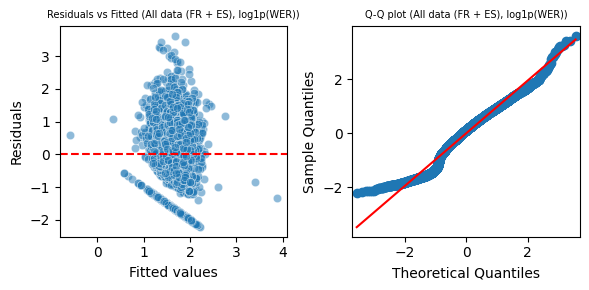


--- OLS (HC3 robust SEs): French only | Outcome = log1p(WER) ---
R^2: 0.079   Adj R^2: 0.077   N: 3067


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.75,0.02,100.44,0.00,1.71,1.78
rms_amplitude,0.13,0.02,7.31,0.00,0.10,0.17
dc_offset,-0.08,0.04,-1.93,0.05,-0.17,0.00
articulation_rate,0.13,0.02,6.84,0.00,0.09,0.16
mean_pitch,-0.25,0.03,-9.35,0.00,-0.30,-0.20
pitch_std_dev,0.05,0.02,2.19,0.03,0.01,0.09
hnr,0.17,0.02,7.15,0.00,0.12,0.21


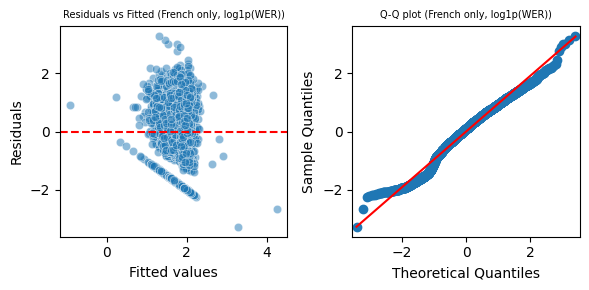


--- OLS (HC3 robust SEs): Spanish only | Outcome = log1p(WER) ---
R^2: 0.055   Adj R^2: 0.052   N: 2416


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.50,0.02,76.04,0.00,1.46,1.54
rms_amplitude,-0.01,0.02,-0.48,0.63,-0.05,0.03
dc_offset,-0.02,0.02,-1.24,0.21,-0.06,0.01
articulation_rate,0.21,0.03,8.15,0.00,0.16,0.26
mean_pitch,-0.14,0.03,-5.52,0.00,-0.19,-0.09
pitch_std_dev,0.02,0.02,0.96,0.34,-0.02,0.06
hnr,0.04,0.02,1.70,0.09,-0.01,0.08


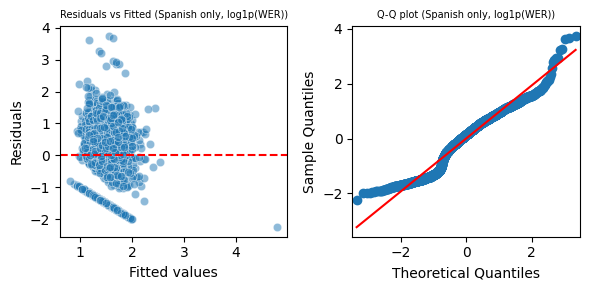

In [14]:
# OLS with HC3 robust SEs, outcome = log1p(WER) to deal with tail outliers

def run_ols_hc3_logwer(df, label, features=FEATURES, outcome=OUTCOME):
    df = df.dropna(subset=features + [outcome]).copy()
    # log-transform outcome
    df["log1p_wer"] = np.log1p(df[outcome])
    X = df[features]
    X = (X - X.mean()) / X.std(ddof=0)
    X = sm.add_constant(X)
    y = df["log1p_wer"]

    model = sm.OLS(y, X).fit(cov_type="HC3")  # robust SEs
    params = model.params.round(2)
    ses    = model.bse.round(2)
    tvals  = model.tvalues.round(2)
    pvals  = model.pvalues.round(2)
    ci     = model.conf_int(alpha=0.05).round(2)

    out = pd.DataFrame({
        "coef": params,
        "robust_se(HC3)": ses,
        "t": tvals,
        "p": pvals,
        "ci_lower": ci[0],
        "ci_upper": ci[1],
    })
    print(f"\n--- OLS (HC3 robust SEs): {label} | Outcome = log1p(WER) ---")
    print(f"R^2: {model.rsquared:.3f}   Adj R^2: {model.rsquared_adj:.3f}   N: {int(model.nobs)}")
    display(out)

    # Residual diagnostics
    fitted = model.fittedvalues
    residuals = model.resid

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted ({label}, log1p(WER))", fontsize=7)

    # Q-Q Plot
    plt.subplot(1,2,2)
    sm.qqplot(residuals, line="s", ax=plt.gca())
    plt.title(f"Q-Q plot ({label}, log1p(WER))", fontsize=7)

    plt.tight_layout()
    plt.show()

    return model, out

# Pooled dataset after your 10% holdout split
all_pooled = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)

# Run three regressions with log1p(WER)
ols_all_log, tab_all_log       = run_ols_hc3_logwer(all_pooled, "All data (FR + ES)")
ols_french_log, tab_fr_log     = run_ols_hc3_logwer(all_pooled.query("language=='french'"), "French only")
ols_spanish_log, tab_es_log    = run_ols_hc3_logwer(all_pooled.query("language=='spanish'"), "Spanish only")


- Using HC3 robust errors reduces spurious significance from heteroskedasticity.  
- Log-transform yields better model fit: the r^2 slightly increased to ~5-7% across regressions, especially for french & spanish
- QQ plots look much better, closer to the linear line
- Residual plots have lost their fanning pattern, generally look better except for the diagonal band --> this is caused by the cases where WER = 0, since log1p(0)=0, all those points collapse to the same transformed outcome, so the regression systematically over or under predicts them. 

**Strongest drivers still seem to be articulation rate, mean pitch**

### Section 2 Summary

- In general, **explained variance is low:** R² values are generally small (<10%, with the highest R^2 being 7.9%), indicating that these features explain only a small share of variation in WER → likely missing other drivers (e.g., acoustic quality, lexical difficulty).
- The most significant features seem to be **articulation rate (+ correlated) and mean pitch (- correlated)**. For french, **RMS amplitude** seemed also to be quite significant. DC offset and HNR seem less significant.
- Signs of coefficients are consistent across regressions, with only mean pitch and DC offset being negatively correlated with WER.
- In terms of key regression assumptions:
    - Multicollinearity does not seem to be a major concern here.
    - Residual plots: show heteroskedasticity (fanning of residuals vs fitted), particularly for French and pooled data.
    - Q–Q plots: show strong deviations in upper tails → residuals are not normal (consistent with occasional extreme WER spikes).
    - Partial residuals: roughly linear patterns but confirm heteroskedasticity.
    - Accounting for these non-linear assumption (e.g. through using log(WER)) improves model fit / residuals.
- In general, French performance seems to be driven by a larger number of features than Spanish --> unclear if this is intrinsic to the languages or the data.

## 3. Regressions using transformed and original WER/features

*Purpose:* Explore the correlation between deltas in transformed & og WER for each line ID, and deltas in features for that line ID. Each predictor is the change in features caused by the Cartesia transform. Also explores whether original WER is correlated to transformed WER

### 3.1 Exploratory Plots

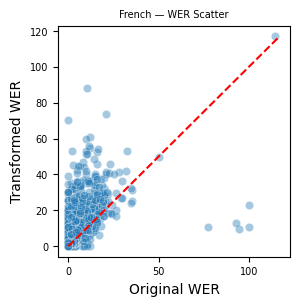

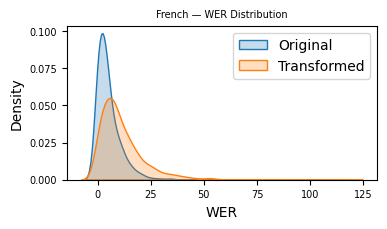

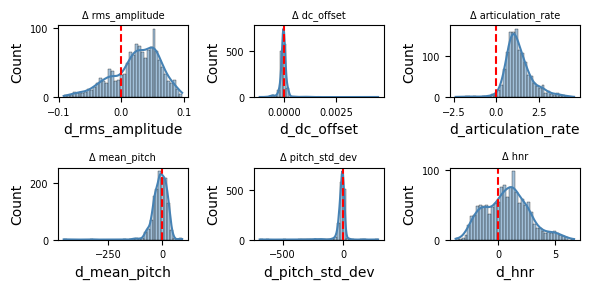

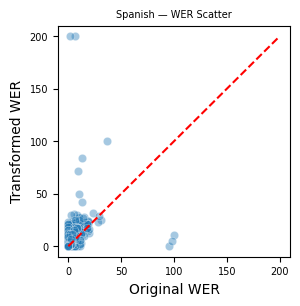

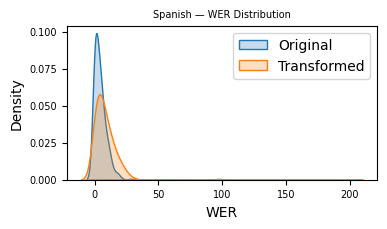

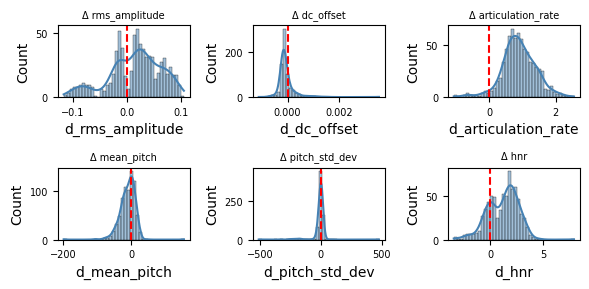

In [20]:
def plot_validation(language, d):
    orig = d["orig"].copy()
    trans = d["trans"].copy()

    # Align by line_id where available
    merged = pd.merge(
        orig, trans,
        on="line_id",
        suffixes=("_orig", "_trans")
    )

    # === Scatter of WER (orig vs trans) ===
    plt.figure(figsize=(3,3))
    sns.scatterplot(x="wer_score_orig", y="wer_score_trans", data=merged, alpha=0.4)
    plt.plot([0, merged[["wer_score_orig","wer_score_trans"]].max().max()],
             [0, merged[["wer_score_orig","wer_score_trans"]].max().max()],
             color="red", linestyle="--")
    plt.xlabel("Original WER")
    plt.ylabel("Transformed WER")
    plt.title(f"{language} — WER Scatter", fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

    # === Distribution of WER (orig vs trans) ===
    plt.figure(figsize=(4,2))
    sns.kdeplot(merged["wer_score_orig"], label="Original", shade=True)
    sns.kdeplot(merged["wer_score_trans"], label="Transformed", shade=True)
    plt.xlabel("WER")
    plt.title(f"{language} — WER Distribution", fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.legend()
    plt.show()

    # === Δ features distributions ===
    dcols = FEATURES
    for col in dcols:
        merged[f"d_{col}"] = merged[f"{col}_trans"] - merged[f"{col}_orig"]

    plt.figure(figsize=(6,3))
    for i, col in enumerate(dcols, 1):
        plt.subplot(2,3,i)
        sns.histplot(merged[f"d_{col}"], bins=40, kde=True, color="steelblue")
        plt.axvline(0, color="red", linestyle="--")
        plt.title(f"Δ {col}", fontsize=7)
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
    plt.tight_layout()
    plt.show()

# Example: run for French and Spanish
plot_validation("French", all_results["french"])
plot_validation("Spanish", all_results["spanish"])

- Scatterplot: general positive correlation but still quite scattered
- Histograms: only hnr and articulation rate seem to have been consistently changed in one direction (the other variables are quite centered around 0) --> makes sense that these deltas would be most significant 
- Overall, distribution of WER in transformed shifted to the right compared to original WER (worsening of the errors after transformation)

### 3.2 Delta Regression - OLS with robust SEs

In [23]:
# Δ-Regression (primary inference) — OLS with robust SEs, with R² output

results_delta = {}

for language, d in all_results.items():
    lp = d["line_paired"].copy()
    if lp.empty:
        print(f"{language}: no line-paired data; skipping Δ-regression.")
        continue

    # Δ-features and Δ outcome
    dcols = [f"d_{c}" for c in FEATURES]
    keep_cols = dcols + ["d_log1p_wer", "speaker_id"]
    lp = lp.replace([np.inf, -np.inf], np.nan).dropna(subset=keep_cols)

    # Standardize Δ-features within this language
    for col in dcols:
        lp[col] = (lp[col] - lp[col].mean()) / lp[col].std(ddof=0)

    # OLS with cluster-robust SEs (by speaker)
    formula = "d_log1p_wer ~ " + " + ".join(dcols)
    ols_cluster = ols(formula, data=lp).fit(
        cov_type="cluster", cov_kwds={"groups": lp["speaker_id"]}
    )
    # Also HC3 (robust but not clustered)
    ols_hc3 = sm.OLS(lp["d_log1p_wer"], sm.add_constant(lp[dcols])).fit(cov_type="HC3")

    # Tidy 2-decimal output (cluster SEs as primary)
    summ = pd.DataFrame({
        "coef": ols_cluster.params.round(2),
        "se_cluster": ols_cluster.bse.round(2),
        "t_cluster": ols_cluster.tvalues.round(2),
        "p_cluster": ols_cluster.pvalues.round(2),
        "ci_lo": ols_cluster.conf_int()[0].round(2),
        "ci_hi": ols_cluster.conf_int()[1].round(2),
        "HC3_se": ols_hc3.bse.round(2),
        "HC3_p": ols_hc3.pvalues.round(2)
    })

    results_delta[language] = {
        "ols_cluster": ols_cluster,
        "ols_hc3": ols_hc3,
        "table": summ
    }

    print(f"\n[{language.upper()}] Δ-Regression (log1p WER), N={len(lp):,}")
    print(f"R^2 (clustered OLS): {ols_cluster.rsquared:.3f}   Adj R^2: {ols_cluster.rsquared_adj:.3f}")
    display(summ.loc[["Intercept"] + dcols])



[FRENCH] Δ-Regression (log1p WER), N=1,336
R^2 (clustered OLS): 0.017   Adj R^2: 0.013


,coef,se_cluster,t_cluster,p_cluster,ci_lo,ci_hi,HC3_se,HC3_p
Intercept,0.74,0.03,23.30,0.00,0.67,0.80,NaN,NaN
d_rms_amplitude,0.04,0.04,1.21,0.23,-0.03,0.11,0.03,0.13
d_dc_offset,-0.04,0.02,-1.65,0.10,-0.08,0.01,0.03,0.16
d_articulation_rate,0.02,0.03,0.45,0.66,-0.05,0.08,0.03,0.63
d_mean_pitch,0.01,0.04,0.20,0.85,-0.08,0.10,0.04,0.82
d_pitch_std_dev,-0.04,0.04,-0.98,0.32,-0.11,0.04,0.03,0.29
d_hnr,0.11,0.04,2.95,0.00,0.04,0.18,0.03,0.00



[SPANISH] Δ-Regression (log1p WER), N=738
R^2 (clustered OLS): 0.005   Adj R^2: -0.003


,coef,se_cluster,t_cluster,p_cluster,ci_lo,ci_hi,HC3_se,HC3_p
Intercept,0.54,0.04,13.43,0.00,0.46,0.62,NaN,NaN
d_rms_amplitude,0.01,0.04,0.20,0.84,-0.08,0.10,0.04,0.83
d_dc_offset,0.01,0.03,0.32,0.75,-0.05,0.06,0.03,0.75
d_articulation_rate,-0.04,0.05,-0.78,0.44,-0.13,0.06,0.05,0.47
d_mean_pitch,0.02,0.05,0.34,0.73,-0.08,0.12,0.04,0.69
d_pitch_std_dev,-0.04,0.05,-0.86,0.39,-0.13,0.05,0.04,0.30
d_hnr,0.05,0.04,1.14,0.26,-0.03,0.13,0.04,0.17


* **Model fit (R²):** Very low (≤2%), reflecting high noise in ΔWER relative to small systematic feature shifts.
* **French:** Only ΔHNR is significant (and positive → higher harmonicity positively correlates with increased transformed WER)
* **Spanish:** No Δfeatures were significant.


### 3.3 Regression: WER transformed ~ WER original + delta features

In [22]:
# Regression: WER_trans ~ WER_orig + Δfeatures (HC3), raw and log1p
def run_wer_map_regression(language_key, d, use_log=False):
    """
    language_key: 'french' or 'spanish'
    d: all_results[language_key] dict with 'orig' and 'trans'
    use_log: False -> raw WER, True -> log1p(WER)
    """
    # Align by line_id within the language
    orig = d["orig"].copy()
    trans = d["trans"].copy()
    merged = pd.merge(
        orig, trans,
        on="line_id", suffixes=("_orig", "_trans")
    )
    if merged.empty:
        print(f"{language_key}: no line-level overlap to regress on.")
        return None, None

    # Build Δ-features
    dcols = []
    for col in FEATURES:
        dname = f"d_{col}"
        merged[dname] = merged[f"{col}_trans"] - merged[f"{col}_orig"]
        dcols.append(dname)

    # Outcome and baseline predictor
    if use_log:
        y = np.log1p(merged["wer_score_trans"])
        x_base = np.log1p(merged["wer_score_orig"])
        outcome_label = "log1p(WER_trans) ~ log1p(WER_orig) + Δfeatures"
    else:
        y = merged["wer_score_trans"]
        x_base = merged["wer_score_orig"]
        outcome_label = "WER_trans ~ WER_orig + Δfeatures"

    # Correlation between original and transformed WER (sanity check)
    r, p = pearsonr(x_base, y)
    print(f"\n[{language_key.upper()}] Correlation (orig vs trans) "
          f"{'on log1p scale' if use_log else 'raw'}: r = {r:.3f}, p = {p:.3g}")

    # Design matrix: standardize predictors for comparability
    X = pd.DataFrame({"wer_orig": x_base})
    for dname in dcols:
        X[dname] = merged[dname]

    X = (X - X.mean()) / (X.std(ddof=0) + 1e-12)
    X = sm.add_constant(X)

    # Fit OLS with HC3 robust SEs
    model = sm.OLS(y, X).fit(cov_type="HC3")

    # Tidy 2-decimal table
    tab = pd.DataFrame({
        "coef": model.params.round(2),
        "robust_se(HC3)": model.bse.round(2),
        "t": model.tvalues.round(2),
        "p": model.pvalues.round(2),
    })
    ci = model.conf_int().round(2)
    tab["ci_lower"] = ci[0]
    tab["ci_upper"] = ci[1]

    print(f"[{language_key.upper()}] {outcome_label}")
    print(f"R^2: {model.rsquared:.3f}   Adj R^2: {model.rsquared_adj:.3f}   N: {int(model.nobs)}")
    display(tab)

    return model, tab

# --- Run for both languages, raw and log1p ---
fr_raw_model,  fr_raw_tab  = run_wer_map_regression("french",  all_results["french"],  use_log=False)
fr_log_model,  fr_log_tab  = run_wer_map_regression("french",  all_results["french"],  use_log=True)

es_raw_model,  es_raw_tab  = run_wer_map_regression("spanish", all_results["spanish"], use_log=False)
es_log_model,  es_log_tab  = run_wer_map_regression("spanish", all_results["spanish"], use_log=True)



[FRENCH] Correlation (orig vs trans) raw: r = 0.466, p = 8.26e-73
[FRENCH] WER_trans ~ WER_orig + Δfeatures
R^2: 0.262   Adj R^2: 0.258   N: 1336


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,11.39,0.26,43.88,0.00,10.88,11.90
wer_orig,4.78,1.11,4.32,0.00,2.62,6.95
d_rms_amplitude,0.11,0.33,0.34,0.74,-0.53,0.75
d_dc_offset,-0.32,0.21,-1.50,0.13,-0.73,0.10
d_articulation_rate,-1.14,0.42,-2.70,0.01,-1.97,-0.31
d_mean_pitch,0.66,0.42,1.56,0.12,-0.17,1.48
d_pitch_std_dev,-0.55,0.36,-1.53,0.13,-1.25,0.15
d_hnr,2.37,0.35,6.75,0.00,1.68,3.05



[FRENCH] Correlation (orig vs trans) on log1p scale: r = 0.554, p = 1.75e-108
[FRENCH] log1p(WER_trans) ~ log1p(WER_orig) + Δfeatures
R^2: 0.334   Adj R^2: 0.331   N: 1336


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,2.15,0.02,103.15,0.00,2.11,2.19
wer_orig,0.50,0.02,20.83,0.00,0.45,0.55
d_rms_amplitude,0.03,0.02,1.41,0.16,-0.01,0.08
d_dc_offset,-0.03,0.03,-1.18,0.24,-0.08,0.02
d_articulation_rate,-0.06,0.03,-2.13,0.03,-0.11,-0.00
d_mean_pitch,0.04,0.03,1.15,0.25,-0.03,0.10
d_pitch_std_dev,-0.05,0.03,-1.64,0.10,-0.10,0.01
d_hnr,0.16,0.03,5.97,0.00,0.11,0.21



[SPANISH] Correlation (orig vs trans) raw: r = 0.234, p = 1.29e-10
[SPANISH] WER_trans ~ WER_orig + Δfeatures
R^2: 0.060   Adj R^2: 0.051   N: 738


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,8.65,0.48,18.03,0.00,7.71,9.58
wer_orig,3.09,1.55,1.99,0.05,0.05,6.13
d_rms_amplitude,0.38,0.78,0.49,0.62,-1.15,1.92
d_dc_offset,0.55,0.54,1.02,0.31,-0.51,1.61
d_articulation_rate,0.27,0.53,0.50,0.61,-0.78,1.31
d_mean_pitch,-0.30,0.62,-0.49,0.63,-1.51,0.91
d_pitch_std_dev,0.11,0.46,0.25,0.81,-0.78,1.01
d_hnr,0.80,0.52,1.55,0.12,-0.21,1.81



[SPANISH] Correlation (orig vs trans) on log1p scale: r = 0.592, p = 5.02e-71
[SPANISH] log1p(WER_trans) ~ log1p(WER_orig) + Δfeatures
R^2: 0.357   Adj R^2: 0.351   N: 738


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.82,0.03,60.98,0.00,1.76,1.87
wer_orig,0.58,0.04,15.28,0.00,0.51,0.66
d_rms_amplitude,0.05,0.04,1.28,0.20,-0.03,0.12
d_dc_offset,-0.01,0.03,-0.38,0.70,-0.06,0.04
d_articulation_rate,-0.01,0.04,-0.22,0.82,-0.10,0.08
d_mean_pitch,0.03,0.04,0.76,0.45,-0.05,0.11
d_pitch_std_dev,-0.05,0.03,-1.58,0.11,-0.12,0.01
d_hnr,0.05,0.03,1.64,0.10,-0.01,0.11


**Overall**
* **French**: Moderate correlation, decent explanatory power
  * Raw: r = 0.47 / R² = 0.26
  * Log: r = 0.55 / R² = 0.33
* **Spanish**: On the raw scale, almost no correlation and little explanatory power; on the log scale, correlation and R^2 improves dramatically. This suggests that extreme outliers in raw WER obscure the relationship, and logging stabilizes it.
  * Raw: r = 0.23 / R² = 0.06
  * Log: r = 0.59 / R² = 0.36

**Key coefficients**
* **French**
  * **wer\_orig**:
    * Strong and highly significant on both scales (coef \~4.8 raw, 0.50 log) ==> original WER strongly predicts transformed WER (which makes sense).
  * **d\_articulation\_rate**:
    * Significant negative effect (raw: –1.14, log: –0.06) ==> if Cartesia increases articulation rate, transformed WER tends to drop relative to what original WER would predict. This is interesting — opposite of the general OLS result (where faster speech worsened WER).
  * **d\_hnr**:
    * Strong positive effect (raw: +2.37, log: +0.16, both highly significant) ==> when Cartesia increases harmonicity, transformed WER rises relative to original. This matches what we saw earlier in Δ-regression.
    * Other Δfeatures (rms, pitch, dc\_offset, pitch\_std\_dev): not significant once controlling for orig WER.
* **Spanish**
  * **wer\_orig**:
    * Borderline on raw (p=0.05), but strong and highly significant on log (coef \~0.58).
  * **Δfeatures**:
    * None are significant (all p > 0.1) ==> cartesia doesn’t systematically alter phonological features in ways that affect WER beyond what original WER already explains.
* **Overall**
  * **Original WER is by far the strongest predictor of transformed WER**. Cartesia doesn’t fundamentally change which utterances are difficult.
  * **French**: Δarticulation\_rate and ΔHNR matter. Cartesia’s modifications to those features systematically shift WER outcomes.
  * **Spanish**: No Δfeature matters — Cartesia’s transformation doesn’t significantly alter performance in a systematic way.

### Section 3 Summary

**Scatterplots (WER\_orig vs WER\_trans):** indicate a general positive correlation but with substantial scatter.
* **WER Distributions:** In both French and Spanish, the transformed WER distribution shifts rightward (higher errors), with fatter right tails — suggesting Cartesia increases error rates overall.
* **Δ-feature histograms:** Cartesia systematically increases **articulation\_rate** and **HNR**, while other features cluster tightly around zero (minimal change). This pattern matches some of the regression findings.

**3.2 Delta Regressions: change in WER ~ change in features**
* This analysis was largely "inconclusive", in that only one of the delta features (delta HNR in french) was significant, and the model fit was very poor. 

**3.3 Transformed WER ~ original WER + change in features**
  * Controlling for original WER dramatically improved model fit (R² higher), which makes sense. This allowed us to pick up two significant features in french, but still none in Spanish.
  * **Original WER was the strongest predictor** in both languages (significant, with coefficients ≈0.5 on log scale). This confirms that utterance difficulty is largely preserved under transformation.
  * **French:** After controlling for WER\_orig, Δarticulation\_rate (negative) and ΔHNR (positive) are significant, consistent with the Δ-regressions.
  * **Spanish:** WER\_orig explained most of the variance; Δfeatures remained insignificant.

**Overall**
* **Whisper performance is primarily stable across Cartesia transformations**: original WER strongly predicts transformed WER.
* **French:** Cartesia systematically increases articulation rate and HNR, and these changes seem to explain part of the observed shifts in WER (faster articulation slightly helps, more harmonicity hurts).
* **Spanish:** Although Cartesia alters articulation rate and HNR similarly, these changes do not significantly affect WER, even once baseline difficulty (original WER) is accounted for.

While section 2 allowed us to view some correlation between phonological features and WER performance, we don't see a similar behavior here with **change** in these phonological features and **change** in WER. This seems to mostly be due to the behavior of the Cartesia transform (see histograms), that does not seem to systematically alter all features in the same way.

## 4. Chi Squared Tests & Binomial Tests
*Purpose* Test whether observed associations in this sample (the dataset) reflect a true relationship in the population or could reasonably be due to sampling variability (null: variables are independent in the population).

### 4.1. Chi Squared Test on whether feature quartiles & WER category (high or low) are independent


[All (FR+ES)] Feature=rms_amplitude
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              10       1361
Q2              31       1340
Q3              57       1313
Q4              19       1352
Chi2=43.676, dof=3, p=1.768e-09, Cramér's V=0.089, N=5483

[All (FR+ES)] Feature=dc_offset
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              28       1343
Q2              50       1321
Q3              22       1348
Q4              17       1354
Chi2=22.161, dof=3, p=6.04e-05, Cramér's V=0.064, N=5483

[All (FR+ES)] Feature=articulation_rate
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              25       1347
Q2              25       1345
Q3              19       1351
Q4              48       1323
Chi2=17.198, dof=3, p=0.0006435, Cramér's V=0.056, N=5483

[All (FR+ES)] Feature=mean_pitch
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              43       1328
Q2              49       1322
Q3              18    

,feature,chi2,p,dof,cramers_v,n
0,rms_amplitude,43.68,1.77e-09,3,0.089,"5,483"
3,mean_pitch,41.93,4.16e-09,3,0.087,"5,483"
4,pitch_std_dev,32.29,4.54e-07,3,0.077,"5,483"
1,dc_offset,22.16,6.04e-05,3,0.064,"5,483"
5,hnr,18.15,0.00041,3,0.058,"5,483"
2,articulation_rate,17.20,0.000644,3,0.056,"5,483"


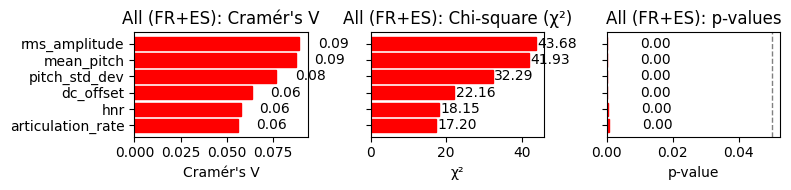


[French] Feature=rms_amplitude
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1               6        761
Q2              29        738
Q3              48        718
Q4              14        753
Chi2=43.719, dof=3, p=1.731e-09, Cramér's V=0.119, N=3067

[French] Feature=dc_offset
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              33        734
Q2              37        730
Q3              15        751
Q4              12        755
Chi2=20.190, dof=3, p=0.000155, Cramér's V=0.081, N=3067

[French] Feature=articulation_rate
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              20        747
Q2              21        746
Q3              18        748
Q4              38        729
Chi2=10.915, dof=3, p=0.01219, Cramér's V=0.060, N=3067

[French] Feature=mean_pitch
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1              35        732
Q2              41        726
Q3              14        752
Q4            

,feature,chi2,p,dof,cramers_v,n
0,rms_amplitude,43.72,1.73e-09,3,0.119,"3,067"
3,mean_pitch,33.98,2e-07,3,0.105,"3,067"
4,pitch_std_dev,21.90,6.83e-05,3,0.085,"3,067"
1,dc_offset,20.19,0.000155,3,0.081,"3,067"
2,articulation_rate,10.92,0.0122,3,0.060,"3,067"
5,hnr,10.80,0.0129,3,0.059,"3,067"


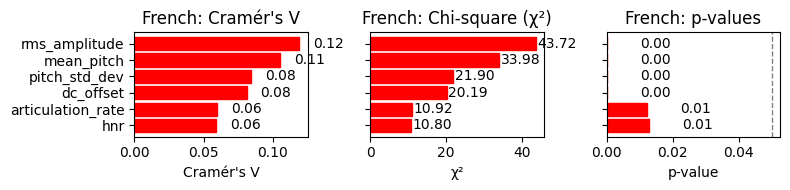


[Spanish] Feature=rms_amplitude
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1               3        601
Q2               6        598
Q3               6        598
Q4               5        599
Chi2=1.210, dof=3, p=0.7506, Cramér's V=0.022, N=2416

[Spanish] Feature=dc_offset
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1               8        596
Q2               4        600
Q3               3        601
Q4               5        599
Chi2=2.823, dof=3, p=0.4197, Cramér's V=0.034, N=2416

[Spanish] Feature=articulation_rate
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1               2        602
Q2               4        600
Q3               5        599
Q4               9        595
Chi2=5.243, dof=3, p=0.1548, Cramér's V=0.047, N=2416

[Spanish] Feature=mean_pitch
WER_cat  High(>30)  Low(<=30)
feat_q                       
Q1               8        596
Q2               4        600
Q3               4        600
Q4               4 

,feature,chi2,p,dof,cramers_v,n
2,articulation_rate,5.24,0.155,3,0.047,"2,416"
4,pitch_std_dev,4.03,0.258,3,0.041,"2,416"
1,dc_offset,2.82,0.42,3,0.034,"2,416"
3,mean_pitch,2.42,0.49,3,0.032,"2,416"
0,rms_amplitude,1.21,0.751,3,0.022,"2,416"
5,hnr,1.21,0.751,3,0.022,"2,416"


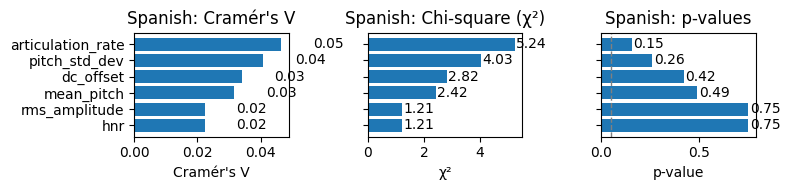

In [39]:
# Chi-square: feature quartiles vs WER category (<=30 vs >30)

WER_THRESHOLD = 30.0        # WER binning: Low (<=30), High (>30)
P_THRESH      = 0.05        # significance threshold for coloring bars red

def _chisq_feature_vs_wer_core(df, feature, wer_col):
    """Return dict with chi2, p, dof, V, N, plus the contingency table; None if not computable."""
    df = df[[feature, wer_col]].dropna().copy()
    if df.empty or df[feature].nunique() < 4:
        return None
    # WER category
    df["WER_cat"] = np.where(df[wer_col] > WER_THRESHOLD, "High(>30)", "Low(<=30)")
    # Feature quartiles (fallback to ranking if ties)
    try:
        df["feat_q"] = pd.qcut(df[feature], 4, labels=["Q1","Q2","Q3","Q4"])
    except Exception:
        df["feat_q"] = pd.qcut(df[feature].rank(method="average"), 4, labels=["Q1","Q2","Q3","Q4"])
    tab = pd.crosstab(df["feat_q"], df["WER_cat"])
    if tab.shape[0] < 2 or tab.shape[1] < 2:
        return None

    chi2, p, dof, expected = chi2_contingency(tab.values, correction=False)
    n = int(tab.values.sum())
    r, k = tab.shape
    denom = n * (min(r-1, k-1))
    v = float(np.sqrt(chi2 / denom)) if denom > 0 else np.nan

    return {"feature": feature, "chi2": chi2, "p": p, "dof": dof, "cramers_v": v, "n": n, "table": tab}

def chisq_feature_summary_for_language(all_results, which="all", wer_col=OUTCOME, verbose=True):
    """
    Build a tidy DataFrame of chi-square stats for every feature for a given language key.
    which ∈ {'all','french','spanish'}.
    If verbose=True, also print the original per-feature contingency tables and stats.
    """
    if which == "all":
        df = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)
        title = "All (FR+ES)"
    else:
        df = all_results[which]["pooled"].copy()
        title = which.capitalize()

    rows = []
    for feat in FEATURES:
        res = _chisq_feature_vs_wer_core(df, feat, wer_col)
        if res is None:
            if verbose:
                print(f"[{title}] {feat}: skipped (insufficient unique values or degenerate table).")
            continue

        # Original table + stats (like before)
        if verbose:
            print(f"\n[{title}] Feature={feat}")
            print(res["table"])
            print(f"Chi2={res['chi2']:.3f}, dof={res['dof']}, p={res['p']:.4g}, "
                  f"Cramér's V={res['cramers_v']:.3f}, N={res['n']}")

        rows.append({k: res[k] for k in ["feature","chi2","p","dof","cramers_v","n"]})

    out = pd.DataFrame(rows).sort_values("cramers_v", ascending=False)
    if not out.empty:
        # Pretty print the summary table too
        display(out.style.format({
            "chi2": "{:.2f}",
            "p": "{:.3g}",
            "cramers_v": "{:.3f}",
            "n": "{:,.0f}"
        }))
    return out, title

def _color_by_p(bars, pvals, p_thresh=P_THRESH):
    """Color bars red if p < P_THRESH."""
    for bar, p in zip(bars, pvals):
        if p < p_thresh:
            bar.set_color("red")

def plot_feature_chisq_results(summary_df, title_prefix, p_thresh=P_THRESH):
    """
    Create 3 horizontal bar charts: Cramér's V, Chi-square, and p-value.
    Bars are colored red when p < p_thresh.
    """
    if summary_df is None or summary_df.empty:
        print(f"{title_prefix}: no usable features for chi-square.")
        return

    sdf = summary_df.copy().sort_values("cramers_v", ascending=False)
    feats   = sdf["feature"].tolist()
    vvals   = sdf["cramers_v"].values
    chi2s   = sdf["chi2"].values
    pvals   = sdf["p"].values
    fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharey=True)

    # --- Cramér's V ---
    ax = axes[0]
    bars0 = ax.barh(feats, vvals)
    _color_by_p(bars0, pvals, p_thresh)
    ax.set_title(f"{title_prefix}: Cramér's V")
    ax.set_xlabel("Cramér's V")
    ax.invert_yaxis()
    for i, v in enumerate(vvals):
        ax.text(v + 0.01, i, f"{v:.2f}", va="center")

    # --- Chi-square ---
    ax = axes[1]
    bars1 = ax.barh(feats, chi2s)
    _color_by_p(bars1, pvals, p_thresh)
    ax.set_title(f"{title_prefix}: Chi-square (χ²)")
    ax.set_xlabel("χ²")
    if np.max(chi2s) > 0:
        for i, v in enumerate(chi2s):
            ax.text(v + np.max(chi2s)*0.01, i, f"{v:.2f}", va="center")

    # --- P-values ---
    ax = axes[2]
    bars2 = ax.barh(feats, pvals)
    _color_by_p(bars2, pvals, p_thresh)
    ax.set_title(f"{title_prefix}: p-values")
    ax.set_xlabel("p-value")
    ax.axvline(p_thresh, color="gray", linestyle="--", linewidth=1)
    for i, p in enumerate(pvals):
        ax.text(p + 0.01, i, f"{p:.2f}", va="center")
    plt.tight_layout()
    plt.show()

sum_all, title_all = chisq_feature_summary_for_language(all_results, "all", verbose=True)
plot_feature_chisq_results(sum_all, title_all)

sum_fr, title_fr   = chisq_feature_summary_for_language(all_results, "french", verbose=True)
plot_feature_chisq_results(sum_fr, title_fr)

sum_es, title_es   = chisq_feature_summary_for_language(all_results, "spanish", verbose=True)
plot_feature_chisq_results(sum_es, title_es)

**Here we test, for each feature and each language, whether the distribution of the feature is associated with the category of WER (which we define as high if >30, low otherwise).** We report p-value, chi square, and cramer's V (which standardizes chi square to fall between 0 and 1, with 0 representing independence and 1 representing perfect association).

**All data (French + Spanish pooled)**
* Significant associations for every feature (all p < 0.05) --> suggests we can reject the null of independence, i.e. these features are associated with WER category.
* Cramér’s V range = 0.056–0.089 → this suggests that the association between features and WER, while statistically significant (based on the p-value), is very weak.
* Strongest associations: rms_amplitude (V=0.089, p≈1.8e-9), mean_pitch (V=0.087, p≈4e-9), pitch_std_dev (V=0.077, p≈4e-7)
* Pooled across languages, WER category (low vs high) is not independent of our features. Certain quartiles of amplitude, pitch, etc. are systematically linked to higher WER risk. We again see **mean pitch** as, relatively speaking, among the highest associated features with WER.

**French only**
* Again all are significant according to p-values.
* Cramér’s V range is 0.059–0.119 → still small, but stronger than for the pooled dataset
* Strongest effects: rms_amplitude (V=0.119, p≈1.7e-9), **mean_pitch** (V=0.105, p≈2e-7), pitch_std_dev & dc_offset (V≈0.08, both p < 1e-4)
* In French, all features show some relationship with WER category; amplitude and pitch are the clearest drivers. The strength of association is however generally weak.

**Spanish only**
* No features are statistically significant (all p > 0.05).
* Cramér’s V also very low (0.02–0.047).
* WER category seems nearly independent of these features. This suggests either:
    * Data structure: maybe Spanish utterances have less variation in these acoustic features (flatter distributions → weaker associations). 
    * WER behavior: Whisper’s errors on Spanish may be less tied to phonology, and more driven by other factors (e.g., lexical/dialect differences that aren’t captured in your acoustic features).
    * Sample size / balance: Spanish dataset is a bit smaller which reduces power, and generally it seems to be a trend across the analysis that the spanish data seems less signficant than th efrench one.

**Overall**
* French seems to be driving the pooled results, and Spanish seems to have no significant feature–WER associations. There was some overlap in the most significant features with previous analyses, namely mean pitch and amplitude.
* This asymmetry aligns with earlier regression analyses (where French features often came up significant, while Spanish results were noisier / weaker).

### 4.2 Chi Squared Test on whether WER distribution for original vs. transformed are independent


[All (FR+ES)] WER category vs Original/Transformed
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original            26       3383
Transformed         91       1983
Row %:
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original         0.008      0.992
Transformed      0.044      0.956
Chi2=81.138, dof=1, p=0.0000, Cramér's V=0.122, N=5483


,slice,chi2,p,cramers_v,n
0,All (FR+ES),81.14,0.00,0.122,"5,483"



[French] WER category vs Original/Transformed
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original            15       1716
Transformed         82       1254
Row %:
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original         0.009      0.991
Transformed      0.061      0.939
Chi2=68.408, dof=1, p=0.0000, Cramér's V=0.149, N=3067


,slice,chi2,p,cramers_v,n
0,French,68.41,0.00,0.149,"3,067"



[Spanish] WER category vs Original/Transformed
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original            11       1667
Transformed          9        729
Row %:
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original         0.007      0.993
Transformed      0.012      0.988
Chi2=1.986, dof=1, p=0.1588, Cramér's V=0.029, N=2416


,slice,chi2,p,cramers_v,n
0,Spanish,1.99,0.16,0.029,"2,416"


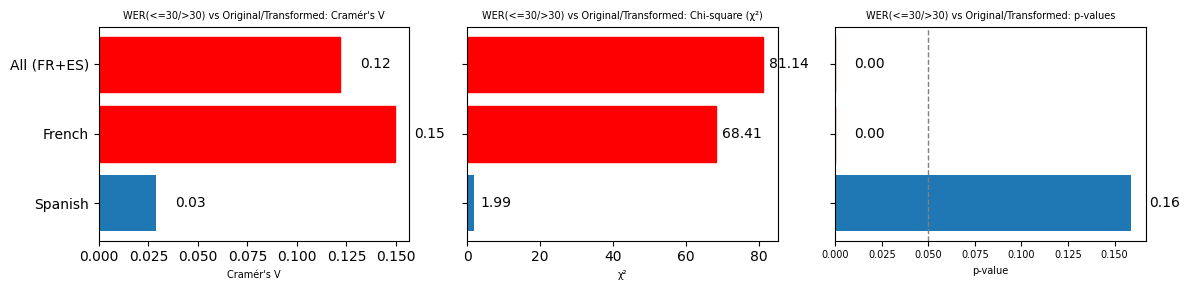

In [25]:
#  Chi-square: WER category (<=30 vs >30) vs Original/Transformed + tables + plots

WER_THRESHOLD = 30.0
P_THRESH = 0.05

def _prep_wer_cat(df, wer_col):
    d = df.dropna(subset=[wer_col, "treatment"]).copy()
    d["WER_cat"] = np.where(d[wer_col] > WER_THRESHOLD, "High(>30)", "Low(<=30)")
    d["treat_label"] = d["treatment"].map({0:"Original", 1:"Transformed"})
    return d

def chisq_wer_vs_treatment_single(df, label, wer_col):
    """Run chi-square on 2x2 (Original/Transformed) x (WER<=30 / >30). Return dict for plotting."""
    d = _prep_wer_cat(df, wer_col)
    tab = pd.crosstab(d["treat_label"], d["WER_cat"])
    if tab.shape != (2,2):
        print(f"[{label}] Degenerate table; skipping.\n{tab}")
        return {"label": label, "chi2": np.nan, "p": np.nan, "v": np.nan, "n": int(tab.values.sum())}

    chi2, p, dof, expected = chi2_contingency(tab.values, correction=False)
    n = int(tab.values.sum())
    # Cramér's V for 2x2: sqrt(chi2 / (n * 1))
    v = float(np.sqrt(chi2 / n)) if n > 0 else np.nan

    row_pct = tab.div(tab.sum(axis=1), axis=0).round(3)

    print(f"\n[{label}] WER category vs Original/Transformed")
    print(tab)
    print("Row %:")
    print(row_pct)
    print(f"Chi2={chi2:.3f}, dof={dof}, p={p:.4f}, Cramér's V={v:.3f}, N={n}")

    return {"label": label, "chi2": chi2, "p": p, "v": v, "n": n}

def chisq_wer_vs_treatment_all(all_results, which="all", wer_col=OUTCOME, verbose=True):
    """
    which ∈ {'all','french','spanish'}.
    Returns a one-row summary DataFrame for the requested slice.
    """
    if which == "all":
        df = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)
        label = "All (FR+ES)"
    else:
        df = all_results[which]["pooled"].copy()
        label = which.capitalize()

    res = chisq_wer_vs_treatment_single(df, label, wer_col)
    out = pd.DataFrame([{
        "slice": res["label"],
        "chi2": res["chi2"],
        "p": res["p"],
        "cramers_v": res["v"],
        "n": res["n"]
    }])
    if verbose:
        display(out.style.format({"chi2":"{:.2f}", "p":"{:.2f}", "cramers_v":"{:.3f}", "n":"{:,.0f}"}))
    return out

def _color_by_p(bars, pvals, p_thresh=P_THRESH):
    for bar, p in zip(bars, pvals):
        if p < p_thresh:
            bar.set_color("red")

def plot_wer_treatment_chisq(summary_df, title="WER category vs Treatment"):
    """
    summary_df: DataFrame with rows for slices (All, French, Spanish) and columns chi2, p, cramers_v.
    Produces 3 horizontal bar charts: Cramér's V, Chi-square, p-value (with p<0.05 colored red).
    """
    if summary_df is None or summary_df.empty:
        print("No data to plot.")
        return

    sdf = summary_df.copy()
    slices = sdf["slice"].tolist()
    chi2s  = sdf["chi2"].values
    pvals  = sdf["p"].values
    vvals  = sdf["cramers_v"].values

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.title(title, fontsize=7)

    # Cramér's V
    ax = axes[0]
    bars0 = ax.barh(slices, vvals)
    _color_by_p(bars0, pvals, P_THRESH)
    ax.set_title(f"{title}: Cramér's V", fontsize=7)
    ax.set_xlabel("Cramér's V", fontsize=7)
    ax.invert_yaxis()
    for i, v in enumerate(vvals):
        ax.text(v + 0.01, i, f"{v:.2f}", va="center")

    # Chi-square
    ax = axes[1]
    bars1 = ax.barh(slices, chi2s)
    _color_by_p(bars1, pvals, P_THRESH)
    ax.set_title(f"{title}: Chi-square (χ²)", fontsize=7)
    ax.set_xlabel("χ²", fontsize=7)
    if np.max(chi2s) > 0:
        for i, v in enumerate(chi2s):
            ax.text(v + max(chi2s)*0.02, i, f"{v:.2f}", va="center")

    # p-values
    ax = axes[2]
    bars2 = ax.barh(slices, pvals)
    _color_by_p(bars2, pvals, P_THRESH)
    ax.set_title(f"{title}: p-values", fontsize=7)
    ax.set_xlabel("p-value", fontsize=7)
    ax.axvline(P_THRESH, color="gray", linestyle="--", linewidth=1)
    for i, p in enumerate(pvals):
        ax.text(p + 0.01, i, f"{p:.2f}", va="center")

    plt.tight_layout()
    plt.show()

# ---- Run for All, French, Spanish; print tables and summary; then plot ----
sum_all = chisq_wer_vs_treatment_all(all_results, "all", verbose=True)
sum_fr  = chisq_wer_vs_treatment_all(all_results, "french", verbose=True)
sum_es  = chisq_wer_vs_treatment_all(all_results, "spanish", verbose=True)

summary = pd.concat([sum_all, sum_fr, sum_es], ignore_index=True)
plot_wer_treatment_chisq(summary, title="WER(<=30/>30) vs Original/Transformed")

**All (FR + ES pooled)**
* Original: only 0.8% of utterances had WER >30 // Transformed: jumps to 4.4% high-WER // Chi²=81.1, p<0.0001, Cramér’s V=0.122 → highly significant, with a small-to-moderate effect size ==> Across the full dataset, transformation makes high-error utterances significantly more common.

**French**
* Original: 0.9% high-WER // Transformed: 6.1% high-WER // Chi²=68.4, p<0.0001, Cramér’s V=0.149 → again strong evidence of a systematic effect ==> Transformation dramatically increases high-error cases in French

**Spanish**
* Original: 0.7% high-WER // Transformed: 1.2% high-WER // Chi²=1.99, p=0.16, V=0.029 → not significant, effect size very small ==> No reliable difference between original and transformed Spanish.

**Overall**
* French is driving the pooled effect. In French, transforming speech to a “standardized” voice introduces a measurable degradation — more utterances fall into the high-WER (>30) bucket. The effect is statistically robust (p<1e-15), with Cramér’s V ~0.15 (small–moderate association).
* Spanish shows no significant shift. Original and transformed Spanish have nearly identical distributions of high vs low WER. Suggests the transformation doesn’t systematically worsen (or improve) Spanish ASR performance and that pooled results (FR+ES) mostly reflect French.

### 4.3 Chi-squared tests and Binomial Test on improvement rates

* **A. Improvement rates per language (binomial test)**
Counts how many paired lines improved (ΔWER < 0) vs worsened/Equal (ΔWER ≥ 0).
Runs a binomial test vs 50/50 to ask: “Does Cartesia help overall for this language?”
* **B. Compare improvement rates across languages (chi-square)**
Builds a 2×2 table: Language × {Improved, Worsened}.
Runs chi-square: “Are improvement rates different in French vs Spanish?”
* **C. Improvement vs Δ-feature quartiles (chi-square)**
For each feature, bins deltas into quartiles.
Crosstabs quartile × {Improved, Worsened} and runs chi-square to see if bigger/smaller feature changes are associated with improvement.

In [38]:
# Improvement & Chi-square suite (clean)

# --- Helper: Chi-square + Cramér's V ---
def chisq_with_cramers_v(table_values, apply_yates=False):
    """
    table_values: numpy array (r x k) contingency table
    apply_yates: use Yates' correction for 2x2 if desired
    Returns: chi2, p, dof, exp, V, N
    """
    chi2, p, dof, exp = chi2_contingency(table_values, correction=apply_yates)
    n = int(table_values.sum())
    r, k = table_values.shape
    denom = n * min(r - 1, k - 1)
    V = float(np.sqrt(chi2 / denom)) if denom > 0 else np.nan
    return chi2, p, dof, exp, V, n

# Improvement rates per language (binomial test)
def improvement_summary(all_results, languages=None):
    if languages is None:
        languages = list(all_results.keys())
    rows = []
    for lang in languages:
        lp = all_results[lang]["line_paired"]
        if lp.empty:
            print(f"[{lang}] No line-paired rows; skipping.")
            continue
        improved = int((lp["d_wer"] < 0).sum())
        worsened = int((lp["d_wer"] >= 0).sum())
        n = improved + worsened
        bt = binomtest(improved, n, p=0.5, alternative="two-sided")
        print(f"\n[{lang.upper()}] Improved={improved}, Worsened/Equal={worsened}, "
              f"N={n}, Binomial p (≠50/50)={bt.pvalue:.2f}")
        rows.append({"language": lang, "Improved": improved, "Worsened": worsened, "N": n, "p_binom": bt.pvalue})
    if rows:
        df = pd.DataFrame(rows).set_index("language")
        display(df.style.format({"p_binom": "{:.2f}"}))
        return df
    return pd.DataFrame()

# Compare improvement rates across languages (chi-square + Cramér's V)
def compare_languages_chisq(impr_df, apply_yates=False):
    if impr_df.shape[0] < 2:
        print("Need at least two languages to compare; skipping FR vs ES chi-square.")
        return
    combo = impr_df[["Improved","Worsened"]].copy()
    chi2, p, dof, exp, V, N = chisq_with_cramers_v(combo.values, apply_yates)
    print("\n[FR vs ES] Chi-square on improvement rates")
    display(combo)
    print(f"Chi2={chi2:.2f}, dof={dof}, p={p:.2f}, Cramér's V={V:.3f}, N={N}")
 
def improvement_vs_delta_quartiles(
    all_results,
    features=None,             # None => use global FEATURES
    languages=None,
    apply_yates=False,
    drop_features=None,        # optional: set/list of base feature names to skip
    collect=True               # default True, always returns DataFrame
):
    if languages is None:
        languages = list(all_results.keys())
    if drop_features is None:
        drop_features = set()
    else:
        drop_features = set(drop_features)

    # Use provided list or fall back to global FEATURES
    if features is None:
        try:
            feat_list = [f for f in FEATURES if f not in drop_features]
        except NameError:
            raise NameError("FEATURES is not defined. Pass `features=[...]` or define global FEATURES.")
    else:
        feat_list = [f for f in features if f not in drop_features]

    results_rows = []

    for lang in languages:
        lp = all_results[lang]["line_paired"].copy()
        if lp.empty:
            continue

        # Outcome: Improved vs Worsened
        lp["Improved"] = np.where(lp["d_wer"] < 0, "Improved", "Worsened")

        for base_f in feat_list:
            dcol = f"d_{base_f}"
            if dcol not in lp.columns:
                continue

            s = lp[[dcol, "Improved"]].dropna()
            if s.empty or not np.issubdtype(s[dcol].dtype, np.number):
                continue
            if s[dcol].nunique() < 4:
                continue

            try:
                s["Q"] = pd.qcut(s[dcol], 4, labels=["Q1","Q2","Q3","Q4"])
            except Exception:
                s["Q"] = pd.qcut(s[dcol].rank(method="average"), 4, labels=["Q1","Q2","Q3","Q4"])

            tab = pd.crosstab(s["Q"], s["Improved"])
            if tab.shape[0] < 2 or tab.shape[1] < 2:
                continue

            chi2, p, dof, exp = chi2_contingency(tab.values, correction=apply_yates)
            N = int(tab.values.sum())
            r, k = tab.shape
            denom = N * min(r - 1, k - 1)
            V = float(np.sqrt(chi2 / denom)) if denom > 0 else np.nan

            results_rows.append({
                "language": lang,
                "feature": base_f,
                "chi2": chi2,
                "dof": dof,
                "p": p,
                "cramers_v": V,
                "N": N
            })

    return pd.DataFrame(results_rows).sort_values(["language","feature"]).reset_index(drop=True)

# --- Run ---
langs = ["french","spanish"]
impr_df = improvement_summary(all_results, languages=langs)
compare_languages_chisq(impr_df)

summary_df = improvement_vs_delta_quartiles(all_results, languages=langs)
display(summary_df)


[FRENCH] Improved=192, Worsened/Equal=1144, N=1336, Binomial p (≠50/50)=0.00

[SPANISH] Improved=83, Worsened/Equal=655, N=738, Binomial p (≠50/50)=0.00


,Improved,Worsened,N,p_binom
language,,,,
french,192,1144,1336,0.00
spanish,83,655,738,0.00



[FR vs ES] Chi-square on improvement rates


,Improved,Worsened
language,,
french,192,1144
spanish,83,655


Chi2=4.04, dof=1, p=0.04, Cramér's V=0.044, N=2074


,language,feature,chi2,dof,p,cramers_v,N
0,french,articulation_rate,6.471737,3,0.090784,0.069600,1336
1,french,dc_offset,3.406177,3,0.333136,0.050493,1336
2,french,hnr,1.265152,3,0.737424,0.030773,1336
3,french,mean_pitch,0.875874,3,0.831246,0.025605,1336
4,french,pitch_std_dev,8.661422,3,0.034148,0.080518,1336
5,french,rms_amplitude,2.578963,3,0.461190,0.043936,1336
6,spanish,articulation_rate,11.395712,3,0.009768,0.124263,738
7,spanish,dc_offset,1.796525,3,0.615692,0.049339,738
8,spanish,hnr,3.489391,3,0.322141,0.068762,738
9,spanish,mean_pitch,1.507807,3,0.680470,0.045201,738


**Binomial Test**
* **French and Spanish:** Binomial p<0.05 → **significantly below 50/50**. In both languages, the transformation makes performance **worse far more often than it improves it**.

**Cross-language chi-squared:** Chi²=4.04, p=0.04, Cramer's V=0.044.
  * P<0.05, suggesting the distributions of improved vs worsened are **not identical across French and Spanish**. Cramer's V is however quite low, suggesting the difference is not strong.

**Improvement vs Δ-feature quartiles**
* **French**: only d_pitch_std_dev is significant (p<0.05), with Cramer's V ~ 0.08 --> significant but weak association between delta feature and improved vs. worsened WER. All other features are not statistically significant.
* **Spanish**: Δ articulation\_rate: p=0.01, V=0.124 → significant, articulation changes seem to influence whether transformation helps or hurts.
==> In both cases only one feature is significant, and doesn't seem to have a strong effect. It seems quartiels of delta features don't explain much about improvement or worsening of WER.

**Overall**
* **Transformation mostly worsens performance in both languages**, with French being more affected (larger chi-square departure from Spanish).
* Improvement is not strongly tied to acoustic deltas — suggests the transformation systematically degrades recognition rather than interacting subtly with features.

### Section 4 Summary

Generally, the distribution of the change in features **does not seem independent** from the distribution of WER (high / low), with the most significant association being with mean pitch (in french particularly). However, we were unable to reach conclusive results of the distribution of the change in features being linked to the distribution of improved vs. worsened WER in transformation. 

For french, the distribution of original and transformed WER **do not seem independent**, whereas in Spanish we cannot reject the null hypothesis that they are.

Finally, we did not find strong correlations / evidence of association between changes in features and improvement rates for WER. Transformation mostly worsesns performance in both languages, but doesn't seem to be linked to changes in features based on chi squared tests.

## Appendix - Robustness Check, Holdout Set
*Purpose* As a quick robustness check, we run the most "conclusive" regressions and chi squared tests above on the holdout set

In [48]:
# HOLDOUT REGRESSION: log WER_trans ~ log WER_orig + Δfeatures (HC3)

def run_holdout_mapping_regression(all_results_holdout, lang, OUTCOME="wer_score", FEATURES=None):
    if FEATURES is None:
        FEATURES = ["rms_amplitude","dc_offset","articulation_rate",
                    "mean_pitch","pitch_std_dev","hnr"]

    orig = all_results_holdout[lang]["orig"][["line_id", OUTCOME] + FEATURES].copy()
    trans = all_results_holdout[lang]["trans"][["line_id", OUTCOME] + FEATURES].copy()

    # Align by line_id and build Δfeatures = trans - orig
    df = pd.merge(orig, trans, on="line_id", suffixes=("_orig","_trans"))
    for f in FEATURES:
        df[f"d_{f}"] = df[f"{f}_trans"] - df[f"{f}_orig"]

    # Outcome & predictors (log1p)
    y = np.log1p(df[f"{OUTCOME}_trans"])
    X = pd.DataFrame({"wer_orig_log": np.log1p(df[f"{OUTCOME}_orig"])})
    for f in FEATURES:
        X[f"d_{f}"] = df[f"d_{f}"]

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit(cov_type="HC3")

    # Compact readout
    keep = ["const","wer_orig_log"] + [f"d_{f}" for f in FEATURES]
    summ = pd.DataFrame({
        "coef": model.params[keep],
        "se(HC3)": model.bse[keep],
        "t": model.tvalues[keep],
        "p": model.pvalues[keep],
    })
    print(f"[{lang.upper()}] Mapping regression on HOLDOUT (log1p WER)")
    print(f"R^2: {model.rsquared:.3f}   Adj R^2: {model.rsquared_adj:.3f}   N: {int(model.nobs)}")
    print(summ.round(3))

run_holdout_mapping_regression(all_results_holdout, "french", OUTCOME="wer_score", FEATURES=FEATURES)
run_holdout_mapping_regression(all_results_holdout, "spanish", OUTCOME="wer_score", FEATURES=FEATURES)

[FRENCH] Mapping regression on HOLDOUT (log1p WER)
R^2: 0.616   Adj R^2: 0.600   N: 172
                         coef  se(HC3)       t      p
const                   0.751    0.195   3.846  0.000
wer_orig_log            0.694    0.068  10.155  0.000
d_rms_amplitude         2.933    2.893   1.014  0.311
d_dc_offset          1082.610  322.166   3.360  0.001
d_articulation_rate     0.374    0.107   3.501  0.000
d_mean_pitch           -0.001    0.002  -0.614  0.540
d_pitch_std_dev         0.000    0.001   0.281  0.779
d_hnr                  -0.097    0.033  -2.891  0.004
[SPANISH] Mapping regression on HOLDOUT (log1p WER)
R^2: 0.540   Adj R^2: 0.492   N: 75
                       coef   se(HC3)      t      p
const                 1.396     0.521  2.677  0.007
wer_orig_log          0.583     0.147  3.960  0.000
d_rms_amplitude       4.006     5.980  0.670  0.503
d_dc_offset          26.930  1603.383  0.017  0.987
d_articulation_rate  -0.057     0.264 -0.215  0.830
d_mean_pitch          0.01

* Somewhat surprisingly, the R^2 are much higher here (54% and 61%) than in the regressions we had performed on the larger training set (~35%).
* In french the most significant features are **d_hnr,d_articulation_rate, d_dc_offset, and of course wer_orig_log**. This is generally consistent with previous results. The signs of the coefficients are however very different, with d_hnr and d_mean_pitch being the only negative ones (in the og regression these were d_dc_offset, d_articulation_rate and d_pitch_std_dev) ==> this suggests that, while the features do seem significant, the model has trouble picking up what the true effect is.
* In spanish no features are significant except **wer_orig_log**. This is also consistent with previous results. The signs of the coefficients are also different, but these are not significant.
* Generally, the model seems to have decente explainability (relatively high R^2), probably mostly driven through original WER. There are some signs of significancy in the features, but we would likely need more / better data, as well as additional complementary features that clearly seem to be missing, to pick up the true effect. 


In [51]:
# === HOLDOUT CHI-SQUARED: High(>30) vs Low WER by Original vs Transformed ===

def holdout_treatment_chisq(all_results_holdout, lang, OUTCOME="wer_score", thresh=30.0):
    df = all_results_holdout[lang]["pooled"].copy()
    df["treat_label"] = np.where(df["treatment"].astype(int)==1, "Transformed", "Original")
    df["WER_cat"] = np.where(df[OUTCOME] > thresh, "High(>30)", "Low(<=30)")

    tab = pd.crosstab(df["treat_label"], df["WER_cat"]).loc[["Original","Transformed"]]
    chi2, p, dof, exp = chi2_contingency(tab.values, correction=False)

    # Cramér's V
    n = tab.values.sum()
    r, k = tab.shape
    V = np.sqrt(chi2 / (n * (min(r-1, k-1) if min(r-1,k-1) > 0 else 1)))

    print(f"[{lang.upper()}] WER High/Low vs Treatment on HOLDOUT  (N={n})")
    print(tab)
    print(f"Chi2={chi2:.2f}, dof={dof}, p={p:.3f}, V={V:.3f}")

holdout_treatment_chisq(all_results_holdout, "french", OUTCOME="wer_score", thresh=30.0)
holdout_treatment_chisq(all_results_holdout, "spanish", OUTCOME="wer_score", thresh=30.0)


[FRENCH] WER High/Low vs Treatment on HOLDOUT  (N=413)
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original            11        230
Transformed         22        150
Chi2=9.24, dof=1, p=0.002, V=0.150
[SPANISH] WER High/Low vs Treatment on HOLDOUT  (N=266)
WER_cat      High(>30)  Low(<=30)
treat_label                      
Original             4        187
Transformed          5         70
Chi2=3.44, dof=1, p=0.063, V=0.114


**French**
* Training set: Chi²=68.4, p<0.0001, Cramér’s V=0.149
* Holdout set: Chi²=9.24, p=0.002, Cramér’s V=0.150
* These results are highly consistent

**Spanish**
* Training set: Chi²=1.99, p=0.16, V=0.029
* Holdout set: Chi²=3.44, p=0.063, Cramér’s V=0.114
* These results seem to indicate a significant association in the holdout set that wasn't present in the training set. However, given how small the sample size is we tend to trust the training set results more.